# 定速巡航PID仿真
为了减小路面测试所带来的风险和时间，尽量在计算机上得到符合实际的仿真，最终得到高质量的控制算法和参数。

为了达到上述目的，需要得到符合实际的汽车参数
1. 油门中性对应的电平值，和对应的DAC value
2. 油门位置对应的电机输出功率

现在假定如下
1. 油门中性位置dac value =1000
2. 油门2000时，对应25kw输出功率

## 仿真模型
car类，具有物理属性
1. 迎风面积，默认2.4 $m^2$ 
2. 质量，默认1600kg
3. 速度，km/h
4. 仿真采样间隔，默认0.2s

car类中有两个method。
1. force_vehicle()根据当前速度，油门深度，给出电机作用在车辆上的力。如果油门深度大于1000，加速的力，如果小于1000，电机制动，减速。
2. vehicle_update()根据电机作用力F，空气阻力Fa，滚动阻力Fr，坡度阻力Fg，计算出车辆加速度，和下一个时间step的速度。


In [1]:
import numpy as np
from simple_pid import PID
import matplotlib.pyplot as plt


# Vehicle model: vehicle()
#
# To develop a mathematical model we start with a force balance for
# the car body. Let v be the speed of the car, m the total mass
# (including passengers), F the force generated by the contact of the
# wheels with the road, and Fd the disturbance force due to gravity,
# friction, and aerodynamic drag.


class car:
    A = 2.4
    m = 1600
    v = 0
    dt = 0.2
    neutral = 1000

    def __init__(self, x,  params={}) -> None:
        m = params.get('m', 1600.)  # mass of car
        A = params.get('A', 2.4)  # frontal area of car
        dt = params.get('dt', 0.2)  # update rate, default 0.2s
        neutral = params.get('neutral', 1000) 
        v = x[0]

    def force_vehicle(self, x, u, params={}):
        """Vehicle force by electric motor.

        Parameters
        ----------
        x : array
            System state: car velocity in km/h
        u : array
            System input: [throttle, gear, road_slope], where throttle is
            a float between 0 and 1, gear is an integer between 1 and 5,
            and road_slope is in rad.

        Returns
        -------
        float
            Vehicle force in N

        """
        v = x[0]                           # vehicle velocity in km/h
        throttle = np.clip(u[0], 600, 2000)     # vehicle throttle
        neutral = params.get('neutral', 1000) 
        ratedPower = params.get('ratedPower', 25e3)  # rated power of car

        if(throttle > neutral):     # acceleration
            Power = (throttle - neutral) / (2000 - neutral) * ratedPower
        elif(throttle < neutral):  # regenerative brake
            if v > 50:
                Power = - 0.8*ratedPower * (neutral - throttle)/(neutral - 600)
            elif v <= 50 and v > 0:
                Power = - 0.8*ratedPower * v/50 * (neutral - throttle)/(neutral - 600)
            else:
                Power = 0
        else:
            Power = 0

        if v == 0:
            F = 0
        else:
            F = Power / (v/3.6)

        return F

    def vehicle_update(self, x, u, params={}):
        """Vehicle dynamics for cruise control system.

        Parameters
        ----------
        x : array
            System state: car velocity in km/h
        u : array
            System input: [throttle, gear, road_slope], where throttle is
            a float between 0 and 1, gear is an integer between 1 and 5,
            and road_slope is in rad.

        Returns
        -------
        float
            Vehicle acceleration

        """
        from math import copysign, sin
        def sign(x): return copysign(1, x)         # define the sign() function

        # Set up the system parameters
        m = params.get('m', 1600.)  # mass of car
        g = params.get('g', 9.8)  # gravity constant
        Cr = params.get('Cr', 0.01)  # rolling friction coef
        Cd = params.get('Cd', 0.32)  # air drag coef
        rho = params.get('rho', 1.3)  # density of air
        A = params.get('A', 2.4)  # frontal area of car
        dt = params.get('dt', 0.2)  # update rate, default 0.2s

        # Define variables for vehicle state and inputs
        v = x[0]/3.6                           # vehicle velocity km/h to m/ss

        theta = u[2]                       # road slope

        # Force generated by the engine
        F = self.force_vehicle(x, u, params)

        # Disturbance forces
        #
        # The disturbance force Fd has three major components: Fg, the forces due
        # to gravity; Fr, the forces due to rolling friction; and Fa, the
        # aerodynamic drag.

        # Letting the slope of the road be \theta (theta), gravity gives the
        # force Fg = m g sin \theta.

        Fg = m * g * sin(theta)

        # A simple model of rolling friction is Fr = m g Cr sgn(v), where Cr is
        # the coefficient of rolling friction and sgn(v) is the sign of v (+/- 1) or
        # zero if v = 0.

        Fr = m * g * Cr * sign(v)

        # The aerodynamic drag is proportional to the square of the speed: Fa =
        # 1/\rho Cd A |v| v, where \rho is the density of air, Cd is the
        # shape-dependent aerodynamic drag coefficient, and A is the frontal area
        # of the car.

        Fa = 1/2 * rho * Cd * A * abs(v) * v

        # Final acceleration on the car
        Fd = Fg + Fr + Fa
        dv = (F - Fd) / m
        v = dv*dt + v

        return v*3.6

## 仿真步骤
1. 设置目标速度，比如50km/h，
2. 设置初始速度，比如5km/h
3. 设置初始油门，比如1000
4. 设置PID参数，比如（100，0，0）
5. 设置pid.sample_time = 0，让PID不是工作在实际控制系统中，而是仿真状态。这样每一次调用pid时，均会进行计算，而不是等待真正的0.2s。
6. 建立class car的实例mut
7. 更新车辆速度，通过调用mut.vehicle_update（）
8. 将当前速度记录进speed列表队尾
9. 调用pid（），计算油门深度。pid(speed[-2], dt=0.2)，由于GPS更新参数延迟，假设有0.2s的延迟，那么pid输入的速度参数就是speed中的倒数第二个。这个延迟参数非常重要，如果0延迟，仿真结果会非常好，但明显与实际情况不符。
10. 将油门参数记录进throttle队尾
11. 不断循环，直到仿真步数大于200步（也就是仿真时长大于0.2s*200=20s）
12. plot仿真结果

In [2]:
def pid_sim(params={}):
    speed_set = params.get('speed_set',50)  
    speed0 = params.get('speed0',5)  
    throttle0 = params.get('throttle0',1000)
    Kp = params.get('Kp', 100)
    Ki = params.get('Ki', 0)
    Kd = params.get('Kd', 0)
    slope = params.get('slope', 0)
    delay = params.get('delay', 0.2)
    nSteps = params.get('nSteps', 200)
    resetPid = params.get('resetPid', False)


    throttle = np.full((1,10),throttle0)
    speed = np.full((1,10),speed0)
    pid = PID(Kp, Ki, Kd, setpoint=speed_set)
    pid.sample_time = 0  # Update everytime when called

    mut = car(x=[speed0], params={})
    # Assume we have a system we want to control in controlled_system
    v = mut.vehicle_update(x=[speed0], u=[throttle0, 0, 0])
    import math
    decp, intp = math.modf(delay / 0.2)
    intp = int(intp)
    
    while True:
        speed = np.append(speed, v)
        # Compute new output from the PID according to the systems current value
        pedal = pid(speed[-intp-2] * decp/0.2 + speed[-intp-1]* (0.2-decp)/0.2, dt=0.2)
        throttle = np.append(throttle, pedal + throttle0)

        # Feed the PID output to the system and get its current value
        v = mut.vehicle_update(x=[v], u=[pedal + throttle0, 0, 0])

        if resetPid == True and Ki != 0 and (speed[-1] - speed_set) * (speed[-2] - speed_set) <= 0 :
            pid = PID(Kp, Ki, Kd, setpoint=speed_set)
            
        if(len(speed) >= nSteps):
            break

    if speed_set > speed0 :
        overshoot = (np.amax(speed)/speed_set - 1)*100
        print("overshoot     = %2.1f"  % overshoot +"%")
        thresh = (np.amax(speed) - speed0)*0.9 + speed0
        res = next(x for x, val in enumerate(speed) if val > thresh)
        print("rise time     = %2.1f" %((res-10)*0.2) + "s" )
    elif speed_set < speed0:
        overshoot = (np.amin(speed)/speed_set - 1)*100
        print("undershoot     = %2.1f"  % overshoot +"%")
        thresh = (np.amin(speed) - speed0)*0.9 + speed0
        res = next(x for x, val in enumerate(speed) if val > thresh)
        print("fall time     = %2.1f" %((res-10)*0.2) + "s" )

    error = abs((np.average(speed[-11:]) / speed_set ) - 1) * 100
    print("control error = %2.1f" % error +"%")
    
    
    T = np.arange(0, nSteps)*0.2
    plt.figure()
    plt.suptitle('Response to speed set response')
    vel_axes = plt.subplot(2, 1, 1)
    throttle_axes = plt.subplot(2, 1, 2)
    # Plot the velocity
    plt.sca(vel_axes)
    plt.ylabel('km/h')
    plt.grid(True)
    plt.plot(T, speed, 'ro')

    # Plot the throttle
    plt.sca(throttle_axes)
    plt.plot(T, throttle, 'b*')
    plt.xlabel('time sec')
    plt.ylabel('pedal position')
    plt.grid(True)
    plt.show()

## 参数优化
### delay的不利影响
对于速度信息延迟一定时间才被控制系统感知，那么会有不利影响，反映在过充和上升时间。

overshoot     = 35.3%
rise time     = 0.8s
control error = 1.8%


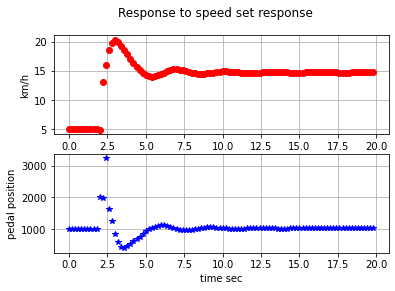

In [3]:
pid_sim(params={'speed_set': 15, 'speed0': 5, 'throttle0': 1000, 'Kp':100, 'Ki':0, 'Kd':0,'delay':0.3,'nSteps':100})

overshoot     = 10.1%
rise time     = 0.4s
control error = 1.8%


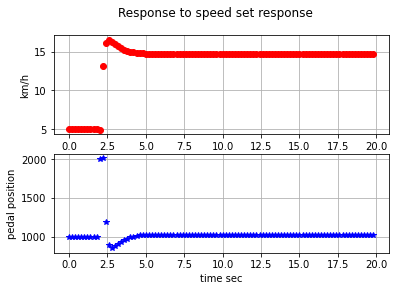

In [4]:
pid_sim(params={'speed_set': 15, 'speed0': 5, 'throttle0': 1000, 'Kp':100, 'Ki':0, 'Kd':0,'delay':0.2,'nSteps':100})

### 寻找合适的Kp参数
暂定0.4s的delay，5 -> 15km/h的速度阶跃。要求不产生明显overshoot情况下，Kp = 50比较合适。另外Kp越大，稳态控制精度越高。

overshoot     = 25.9%
rise time     = 0.6s
control error = 1.8%


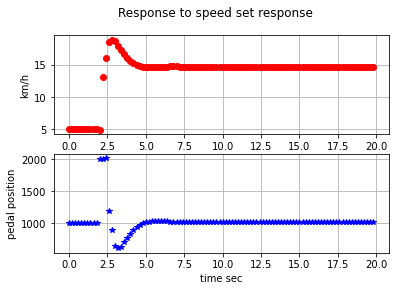

In [5]:
pid_sim(params={'speed_set': 15, 'speed0': 5, 'throttle0': 1000, 'Kp':100, 'Ki':0, 'Kd':0,'delay':0.4,'nSteps':100})

overshoot     = -2.5%
rise time     = 0.8s
control error = 3.5%


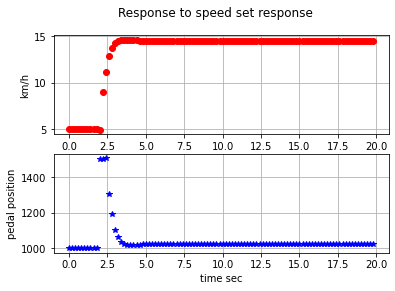

In [6]:
pid_sim(params={'speed_set': 15, 'speed0': 5, 'throttle0': 1000, 'Kp':50, 'Ki':0, 'Kd':0,'delay':0.4,'nSteps':100})

暂定0.4s的delay，5 -> 60km/h的速度阶跃。要求不产生明显overshoot情况下，Kp = 100比较合适。Kp继续增大，由于输出功率限制的缘故，上升时间也不会继续改善，反而会导致震荡。

overshoot     = -6.0%
rise time     = 8.2s
control error = 6.0%


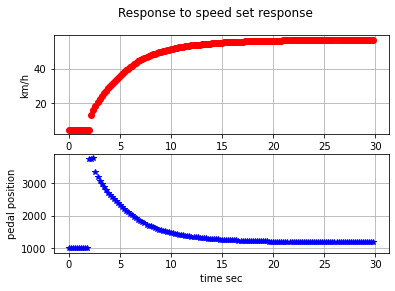

In [7]:
pid_sim(params={'speed_set': 60, 'speed0': 5, 'throttle0': 1000, 'Kp':50, 'Ki':0, 'Kd':0,'delay':0.4,'nSteps':150})

overshoot     = -3.1%
rise time     = 7.2s
control error = 3.1%


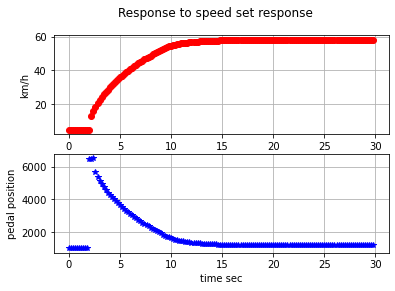

In [8]:
pid_sim(params={'speed_set': 60, 'speed0': 5, 'throttle0': 1000, 'Kp':100, 'Ki':0, 'Kd':0,'delay':0.4,'nSteps':150})

overshoot     = 0.3%
rise time     = 7.8s
control error = 0.6%


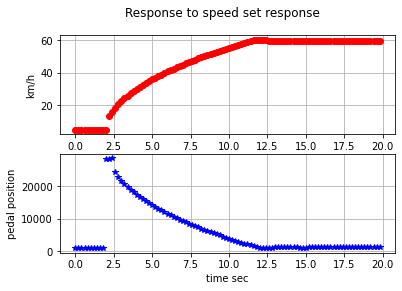

In [9]:
pid_sim(params={'speed_set': 60, 'speed0': 5, 'throttle0': 1000, 'Kp':500, 'Ki':0, 'Kd':0,'delay':0.4,'nSteps':100})

overshoot     = 1.1%
rise time     = 8.0s
control error = 0.5%


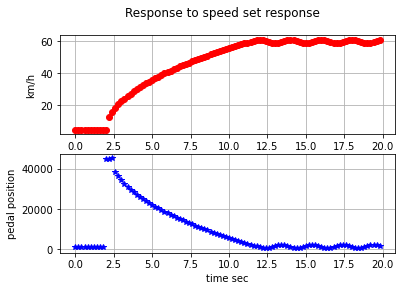

In [10]:
pid_sim(params={'speed_set': 60, 'speed0': 5, 'throttle0': 1000, 'Kp':800, 'Ki':0, 'Kd':0,'delay':0.4,'nSteps':100})

暂定0.4s的delay，5 -> 120km/h的速度阶跃。要求不产生明显overshoot情况下，Kp = 200比较合适。

overshoot     = -3.6%
rise time     = 42.8s
control error = 3.6%


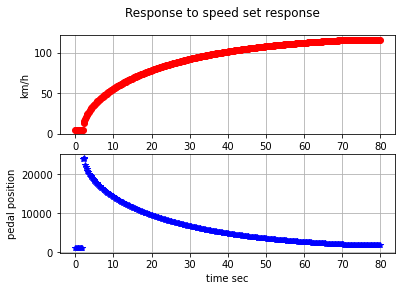

In [11]:
pid_sim(params={'speed_set': 120, 'speed0': 5, 'throttle0': 1000, 'Kp':200, 'Ki':0, 'Kd':0,'delay':0.4,'nSteps':400})

从上述仿真来看，目标速度越大，Kp需要越大，以保证合适的上升时间和控制精度。按照 Kp = speed_set/60 * 100 来进行设置。
## 合适的Ki参数
对于速度阶跃，Ki参数保证的是整体速度error曲线积分为0。所以，如果速度阶跃起始速度离目标速度远，会导致有明显的overshoot，而且保持overshoot的时间很长，导致明显的超速违章可能。这个仿真结果与实车测试结果完全相符合。这一现象，有专门的讨论，而且有多种成熟的解决方案，参考 https://en.wikipedia.org/wiki/Integral_windup

所以应该改变策略，最初采用瞬态控制，借助Ki参数，迅速到达目标速度，然后将PID控制器中的integral error部分重置，进入稳态控制。

overshoot     = 10.6%
rise time     = 9.8s
control error = 0.8%


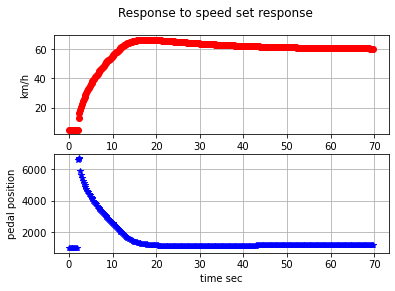

In [12]:
pid_sim(params={'speed_set': 60, 'speed0': 5, 'throttle0': 1000, 'Kp':100, 'Ki':5, 'Kd':0,'delay':0.4,'nSteps':350,'resetPid':False})

借助Ki的帮助，当瞬时速度穿越目标速度后，重置PID，进入稳态控制。此策略有明显的优势，在控制精度，overshoot，响应时间，均明显优于之前的策略。

overshoot     = 1.0%
rise time     = 8.0s
control error = 0.2%


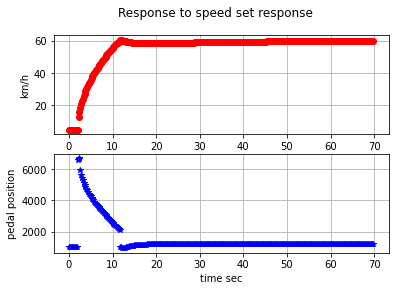

In [13]:
pid_sim(params={'speed_set': 60, 'speed0': 5, 'throttle0': 1000, 'Kp':100, 'Ki':5, 'Kd':0,'delay':0.4,'nSteps':350,'resetPid':True})

overshoot     = 0.0%
rise time     = 7.8s
control error = 2.0%


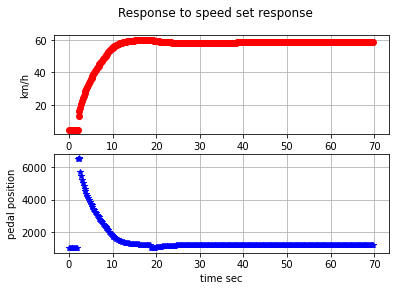

In [14]:
pid_sim(params={'speed_set': 60, 'speed0': 5, 'throttle0': 1000, 'Kp':100, 'Ki':1, 'Kd':0,'delay':0.4,'nSteps':350,'resetPid':True})

overshoot     = 0.6%
rise time     = 7.8s
control error = 0.6%


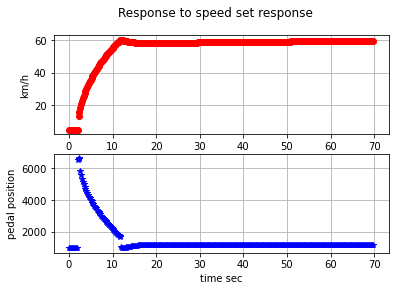

In [15]:
pid_sim(params={'speed_set': 60, 'speed0': 5, 'throttle0': 1000, 'Kp':100, 'Ki':3, 'Kd':0,'delay':0.4,'nSteps':350,'resetPid':True})

重置PID时，会发生油门跳变，从满油门>2000，瞬间下降，可能会导致乘客不舒服。减小Ki有助于改善。Ki=3比较合适。

对负向速度阶跃测试

undershoot     = -2.8%
fall time     = -2.0s
control error = 0.7%


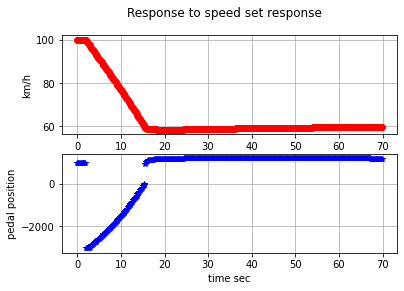

In [16]:
pid_sim(params={'speed_set': 60, 'speed0': 100, 'throttle0': 1000, 'Kp':100, 'Ki':3, 'Kd':0,'delay':0.4,'nSteps':350,'resetPid':True})